# Amazon (AMZN) Stock Price Prediction using LSTM

## Step 1: Project Overview and Setup

This notebook aims to predict the closing price of Amazon (AMZN) stock using a Long Short-Term Memory (LSTM) neural network. We will go through the process of collecting data, preprocessing it, building and training the model, and finally evaluating its performance.

### 1.1 - Import Libraries

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pickle

## Step 2: Data Collection

We will use the `yfinance` library to download historical stock data for Amazon (AMZN) from January 1, 2020, to December 31, 2024.

In [98]:
ticker_symbol = 'AMZN'
stock_data = yf.download(ticker_symbol, start='2020-01-01', end='2024-12-31')

C:\Users\teixvibr\AppData\Local\Temp\ipykernel_27756\3302610639.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


## Step 3: Exploratory Data Analysis (EDA)

In this step, we will explore the data to understand its structure, check for missing values, and visualize key features.

In [99]:
# Get the shape and check for missing values
print(f"Data Shape: {stock_data.shape}")
print("\nMissing Values:")
print(stock_data.isnull().sum())

Data Shape: (1257, 5)

Missing Values:
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64


In [100]:
# Create copy of the data for plotting
plot_data = stock_data.copy()

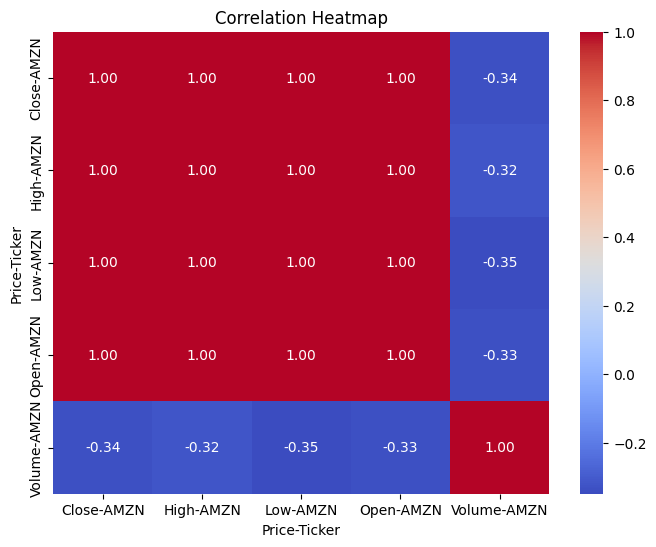

In [101]:
plt.figure(figsize=(8, 6))
sns.heatmap(plot_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

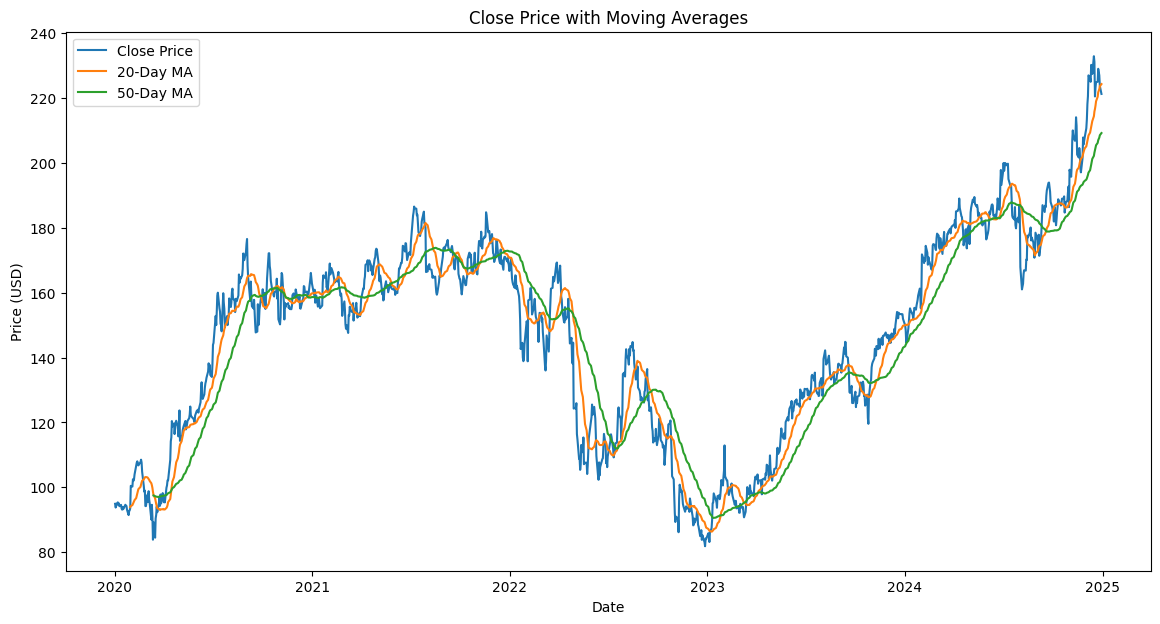

In [102]:
plot_data['MA20'] = plot_data['Close'].rolling(window=20).mean()
plot_data['MA50'] = plot_data['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(plot_data['Close'], label='Close Price')
plt.plot(plot_data['MA20'], label='20-Day MA')
plt.plot(plot_data['MA50'], label='50-Day MA')
plt.title('Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

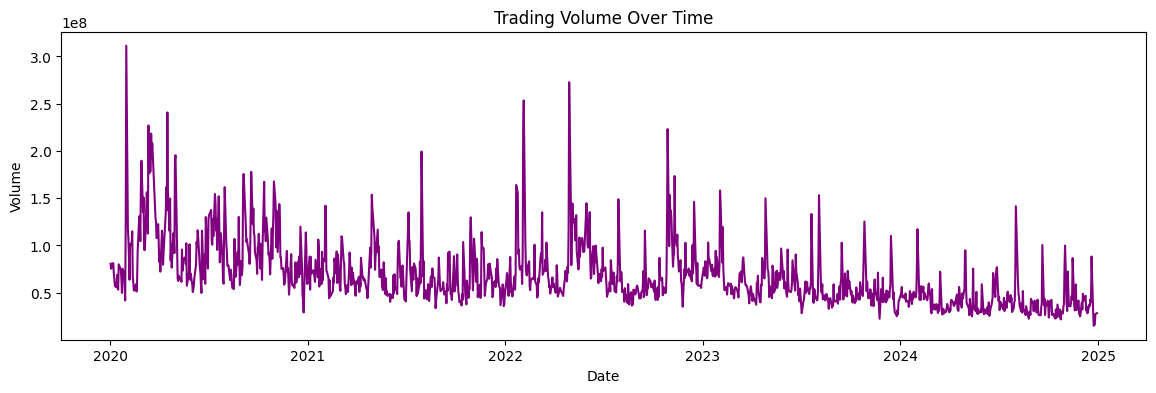

In [103]:
plt.figure(figsize=(14, 4))
plt.plot(plot_data.index, plot_data['Volume'], color='purple')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## Step 4: Data Preprocessing

Here, we will prepare the data for the LSTM model. This involves splitting the data, scaling it correctly to avoid data leakage, and then creating sequences for the time-series model.

In [104]:
# 1. Split the data into training and testing sets (80-20 split)
train_size = int(len(stock_data) * 0.8)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

# 2. Initialize the scaler and fit it ONLY on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

# 3. Transform both the training and testing data using the fitted scaler
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

print(f"Training data shape: {train_scaled.shape}")
print(f"Test data shape: {test_scaled.shape}")

Training data shape: (1005, 5)
Test data shape: (252, 5)


In [105]:
# 4. Create sequences for training and testing
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        # The target is the 'Close' price, which is the first column (index 0)
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (945, 60, 5)
y_train shape: (945,)
X_test shape: (192, 60, 5)
y_test shape: (192,)


## Step 5: LSTM Model Development and Training

Now we'll define, compile, and train the LSTM model using the preprocessed data.

In [107]:
# Set seeds for reproducibility
tf.random.set_seed(101)
np.random.seed(101)

# Define the input shape from your training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build a more robust LSTM model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model with a specific Adam learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

# Display the model's architecture
model.summary()

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.5795

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 0.5715 - val_loss: 0.4171
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.3947

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.3939 - val_loss: 0.3840
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3631

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.3627 - val_loss: 0.3722
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3413

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.3409 - val_loss: 0.3619
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3245

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.3242 - val_loss: 0.3457
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3068

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.3067 - val_loss: 0.3396
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2915

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.2912 - val_loss: 0.3224
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2811

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.2807 - val_loss: 0.3156
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2643

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.2641 - val_loss: 0.3042
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2496

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.2494 - val_loss: 0.2894
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2359

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.2357 - val_loss: 0.2878
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2232

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.2230 - val_loss: 0.2703
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2148

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.2146 - val_loss: 0.2487
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2010 - val_loss: 0.2626
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.1913

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.1911 - val_loss: 0.2392
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1808

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.1806 - val_loss: 0.2388
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1716

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.1714 - val_loss: 0.2245
Epoch 18/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1621

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.1619 - val_loss: 0.2131
Epoch 19/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1530

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.1529 - val_loss: 0.2073
Epoch 20/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1459

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.1458 - val_loss: 0.1718
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1388

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.1387 - val_loss: 0.1627
Epoch 22/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.1328 - val_loss: 0.1820
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1263

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.1261 - val_loss: 0.1576
Epoch 24/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.1204 - val_loss: 0.1654
Epoch 25/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.1147 - val_loss: 0.1693
Epoch 26/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.1081

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.1081 - val_loss: 0.1436
Epoch 27/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1038

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.1037 - val_loss: 0.1020
Epoch 28/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1000

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0999 - val_loss: 0.0971
Epoch 29/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0950 - val_loss: 0.1018
Epoch 30/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0909 - val_loss: 0.1300
Epoch 31/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0869 - val_loss: 0.1095
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0827 - val_loss: 0.1030
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0798

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0797 - val_loss: 0.0939
Epoch 34/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0769 - val_loss: 0.0972
Epoch 35/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0725

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0725 - val_loss: 0.0872
Epoch 36/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0693

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0693 - val_loss: 0.0729
Epoch 37/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0678 - val_loss: 0.0897
Epoch 38/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0656 - val_loss: 0.0744
Epoch 39/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0625 - val_loss: 0.0794
Epoch 40/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0609

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 0.0609 - val_loss: 0.0589
Epoch 41/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0591

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0591 - val_loss: 0.0566
Epoch 42/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.0570 - val_loss: 0.0622
Epoch 43/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 0.0545 - val_loss: 0.0620
Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0521

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - loss: 0.0521 - val_loss: 0.0539
Epoch 45/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0505 - val_loss: 0.0646
Epoch 46/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0494

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0494 - val_loss: 0.0489
Epoch 47/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0471 - val_loss: 0.0546
Epoch 48/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0456 - val_loss: 0.0587
Epoch 49/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0446

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - loss: 0.0446 - val_loss: 0.0457
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 530ms/step - loss: 0.0432 - val_loss: 0.1690
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0436

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 0.0435 - val_loss: 0.0368
Epoch 52/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0412 - val_loss: 0.0378
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0393 - val_loss: 0.0374
Epoch 54/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0378 - val_loss: 0.0379
Epoch 55/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0375 - val_loss: 0.0397
Epoch 56/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0360 - val_loss: 0.0396
Epoch 57/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0356 - val_loss: 0.0385
Epoch 58/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0341 - val_loss: 0.0492
Epoch 59/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0330

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.0330 - val_loss: 0.0341
Epoch 60/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0330 - val_loss: 0.0496
Epoch 61/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0313

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0313 - val_loss: 0.0286
Epoch 62/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0307

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0307 - val_loss: 0.0283
Epoch 63/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 64/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0289 - val_loss: 0.0292
Epoch 65/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0283

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - loss: 0.0284 - val_loss: 0.0282
Epoch 66/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0276 - val_loss: 0.0406
Epoch 67/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0266 - val_loss: 0.0337
Epoch 68/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.0262 - val_loss: 0.0354
Epoch 69/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0256 - val_loss: 0.0304
Epoch 70/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0249 - val_loss: 0.0297
Epoch 71/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0241

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0241 - val_loss: 0.0279
Epoch 72/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.0237 - val_loss: 0.0333
Epoch 73/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - loss: 0.0226 - val_loss: 0.0324
Epoch 74/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0227

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 75/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0221

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 76/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - loss: 0.0213 - val_loss: 0.0214
Epoch 77/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 0.0211 - val_loss: 0.0234
Epoch 78/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - loss: 0.0208 - val_loss: 0.0269
Epoch 79/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0199 - val_loss: 0.0317
Epoch 80/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0195 - val_loss: 0.0239
Epoch 81/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0192 - val_loss: 0.0277
Epoch 82/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0185 - val_loss: 0.0504
Epoch 83/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0179 - val_loss: 0.0262
Epoch 84/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0175

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0175 - val_loss: 0.0210
Epoch 85/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.0175 - val_loss: 0.0265
Epoch 86/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.0174 - val_loss: 0.1181
Epoch 87/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0167

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0167 - val_loss: 0.0196
Epoch 88/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.0162 - val_loss: 0.0261
Epoch 89/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0158 - val_loss: 0.0240
Epoch 90/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.0151 - val_loss: 0.0202
Epoch 91/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0151 - val_loss: 0.0286
Epoch 92/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0150 - val_loss: 0.0485
Epoch 93/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 0.0150 - val_loss: 0.0241
Epoch 94/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0145 - val_loss: 0.0643
Epoch 95/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0149

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 96/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0142 - val_loss: 0.0196
Epoch 97/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0137 - val_loss: 0.0233
Epoch 98/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0129 - val_loss: 0.0194
Epoch 99/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0131 - val_loss: 0.0175
Epoch 100/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0134 - val_loss: 0.0195


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 60, 256)        │       268,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,027 (5.37 MB)

 Trainable params: 469,171 (1.79 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 938,344 (3.58 MB)

## Step 6: Model Evaluation

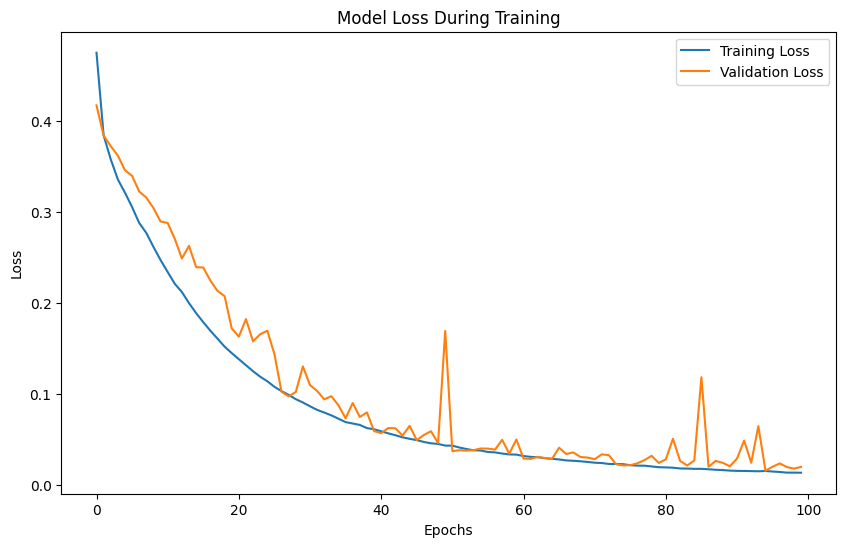

In [108]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Mean Absolute Error (MAE): 9.08
Root Mean Squared Error (RMSE): 11.98
R-squared (R2): 0.37
Mean Absolute Percentage Error (MAPE): 4.54%


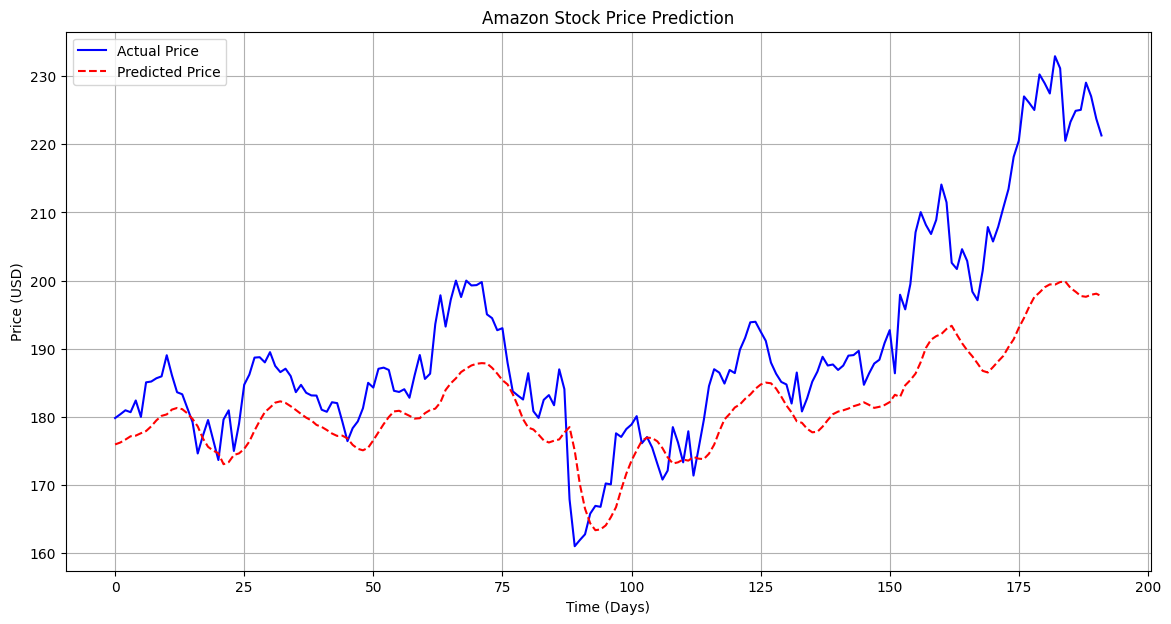

In [109]:
# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions to the original price scale
# We create a dummy array matching the scaler's expected input shape
dummy_predictions = np.zeros((len(predictions_scaled), X_train.shape[2]))
dummy_predictions[:, 0] = predictions_scaled.flatten()
predictions_descaled = scaler.inverse_transform(dummy_predictions)[:, 0]

# Inverse transform the actual test values for comparison
dummy_y_test = np.zeros((len(y_test), X_train.shape[2]))
dummy_y_test[:, 0] = y_test.flatten()
y_test_descaled = scaler.inverse_transform(dummy_y_test)[:, 0]

# Evaluate the model's performance
mae = mean_absolute_error(y_test_descaled, predictions_descaled)
rmse = np.sqrt(mean_squared_error(y_test_descaled, predictions_descaled))
r2 = r2_score(y_test_descaled, predictions_descaled)
mape = np.mean(np.abs((y_test_descaled - predictions_descaled) / y_test_descaled)) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_descaled, color='blue', label='Actual Price')
plt.plot(predictions_descaled, color='red', label='Predicted Price', linestyle='--')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Step 7: Saving Artifacts

Finally, we save the scaler object for future use. The best model has already been saved during training by the `ModelCheckpoint` callback.

In [110]:
# Save the scaler for future inference
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)